## Imports & Housekeeping 

In [62]:
#Imports
import numpy as np
import networkx as nx

import cv2
from skimage import color

import os
from PIL import Image

from enum import Enum

import joblib

import tensorflow as tf
from tensorflow import keras  
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
dataset_loaded = False

In [14]:
CIRCUIT_TEST_DIRECTORY = "/content/circuits/test/"
CIRCUIT_TRAIN_DIRECTORY = "/content/circuits/train/"
CIRCUIT_IMG_DIM = (416, 416)

COMPONENTS = { 'voltageSource' : "/content/voltageSource/train/",
               'resistor' : "/content/resistor/train/Unlabeled/",
               'neither' : "/content/neither/train/"}

LABELS = list(COMPONENTS.keys())

CLASSIFIER_NAME = "handy_classifier.model"

WINDOW_SIZE = (100,100)

class SystemMode(Enum):
  # For system to check if 
  # it should train the model or produce results. 
  TRAIN = 1 # System should check this before training the recognition model
  INFER = 2 # System shouldn't train the model if this is the mode, and should only return results. 

HANDYMODE = SystemMode.TRAIN

if not dataset_loaded:
  # Download Circuits Dataset
  !curl -L "https://app.roboflow.com/ds/prpJBSrVLX?key=sp1toLj1XO" > roboflow.zip; mkdir circuits; unzip roboflow.zip -d "/content/circuits/"; rm roboflow.zip
  # Download Voltage Sources Dataset
  !curl -L "https://app.roboflow.com/ds/kqohTi06tW?key=XxEuXCy4JO" > roboflow.zip; mkdir voltageSource; unzip roboflow.zip -d "/content/voltageSource/"; rm roboflow.zip
  # Download Resistors Dataset
  !curl -L "https://app.roboflow.com/ds/cM2GEr6twA?key=khYWnfKNzh" > roboflow.zip; mkdir resistor; unzip roboflow.zip -d "/content/resistor/"; rm roboflow.zip
  # Download Neither Dataset
  !curl -L "https://app.roboflow.com/ds/9Nbdd8J8fq?key=TVWzg45FHL" > roboflow.zip; mkdir neither; unzip roboflow.zip -d "/content/neither/"; rm roboflow.zip
  dataset_loaded = True

## Circuit Recognition

*Input:* Image \\
*Output:* Directed Graph

#### Helper Functions

In [6]:
# Split the image into 4x4 pieces 
def split_image(img, divide_into = 4):
  #img is np nd.array
  img_shape = img.shape

  block_shape = list(img.shape)
  block_shape[0] = int(block_shape[0]/divide_into)
  block_shape[1] = int(block_shape[1]/divide_into)

  blocks = []

  for i in range(divide_into):
    for j in range(divide_into):
      x_start = block_shape[0]*i
      x_end = x_start + block_shape[0]
      y_start = block_shape[1]*j
      y_end = y_start + block_shape[1]

      blocks.append( img[ x_start:x_end, 
                          y_start:y_end, :])

  return np.array(blocks)

In [7]:
def is_img_empty(img):
  # # Smoothen to remove noise
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(img,-1,kernel)
    median = cv2.medianBlur(dst,5)

    # # Sharpen 
    kernel = np.array([[-1,-1,-1,-1,-1], [-1,-1,-1,-1,-1], [-1, -1, 25, -1, -1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]])
    sharp_img = cv2.filter2D(median, -1, kernel)

    # # Grayscale
    gray_img = color.rgb2gray(sharp_img)

    # # Binarize 
    threshold = 0.6
    bin_img = (255 - (((gray_img) > threshold) * 255)).astype('uint8')
    
    num_zeros = (bin_img == 0).sum()
    num_ones = (bin_img == 255).sum()

    empty_probability = num_zeros/(num_zeros + num_ones)

    return ((empty_probability == 1), empty_probability)


In [50]:
def load_dataset_volsrc():
  # Return Numpy array containing all the images of resistors and 
  dataframe = []
  print('loading dataset...')

  vs_path = COMPONENTS['voltageSource']
  r_path = COMPONENTS['resistor']
  n_path = COMPONENTS['neither']

  for img in os.listdir(vs_path):
    if '.jpg' in img:
      loaded_img = cv2.resize( cv2.imread(vs_path + img), WINDOW_SIZE, interpolation = cv2.INTER_AREA)
      dataframe.append((loaded_img, [1,]))
  print('All voltageSource images loaded')
  
  for img in os.listdir(r_path):
    if '.jpg' in img:
      loaded_img = cv2.resize( cv2.imread(r_path + img), WINDOW_SIZE, interpolation = cv2.INTER_AREA)
      dataframe.append((loaded_img, [0,]))
  print('All resistor images loaded')

  for img in os.listdir(n_path):
    if '.jpg' in img:
      loaded_img = cv2.resize( cv2.imread(n_path + img), WINDOW_SIZE, interpolation = cv2.INTER_AREA)
      dataframe.append((loaded_img, [0,]))
  print('Everything else loaded')

  dataframe = np.array(dataframe, dtype=object)
  
  np.random.shuffle(dataframe)

  percentage = 99
  row_count = dataframe.shape[0]
  partition = int(row_count*percentage/100)

  print(dataframe.shape)

  train = dataframe[:partition,:]
  test = dataframe[partition:,:]   

  x_train = list()
  y_train = list()
  
  for i in train:
    x_train.append(i[0])
    y_train.append(i[1])

  x_train = np.array(x_train)
  y_train = to_categorical(np.array(y_train))
  
  x_test = list()
  y_test = list()

  for i in test:
    x_test.append(i[0])
    y_test.append(i[1])

  x_test = np.array(x_test)
  y_test = to_categorical(np.array(y_test))
  print('Dataset loading complete. \\Files: x_train, x_test, y_train, y_test')
  return (x_train, x_test, y_train, y_test)

In [51]:
def load_dataset_resistors():
  # Return Numpy array containing all the images of resistors and 
  dataframe = []
  print('loading dataset...')

  vs_path = COMPONENTS['voltageSource']
  r_path = COMPONENTS['resistor']
  n_path = COMPONENTS['neither']

  for img in os.listdir(vs_path):
    if '.jpg' in img:
      loaded_img = cv2.resize( cv2.imread(vs_path + img), WINDOW_SIZE, interpolation = cv2.INTER_AREA)
      dataframe.append((loaded_img, [0,]))
  print('All voltageSource images loaded')
  
  for img in os.listdir(r_path):
    if '.jpg' in img:
      loaded_img = cv2.resize( cv2.imread(r_path + img), WINDOW_SIZE, interpolation = cv2.INTER_AREA)
      dataframe.append((loaded_img, [1,]))
  print('All resistor images loaded')

  for img in os.listdir(n_path):
    if '.jpg' in img:
      loaded_img = cv2.resize( cv2.imread(n_path + img), WINDOW_SIZE, interpolation = cv2.INTER_AREA)
      dataframe.append((loaded_img, [0,]))
  print('Everything else loaded')

  dataframe = np.array(dataframe, dtype=object)
  
  np.random.shuffle(dataframe)

  percentage = 99
  row_count = dataframe.shape[0]
  partition = int(row_count*percentage/100)

  print(dataframe.shape)

  train = dataframe[:partition,:]
  test = dataframe[partition:,:]   

  x_train = list()
  y_train = list()
  
  for i in train:
    x_train.append(i[0])
    y_train.append(i[1])

  x_train = np.array(x_train)
  y_train = to_categorical(np.array(y_train))
  
  x_test = list()
  y_test = list()

  for i in test:
    x_test.append(i[0])
    y_test.append(i[1])

  x_test = np.array(x_test)
  y_test = to_categorical(np.array(y_test))
  print('Dataset loading complete. \\Files: x_train, x_test, y_train, y_test')
  return (x_train, x_test, y_train, y_test)

In [96]:
def calculate_centroid(xmin, ymin, xmax, ymax):
  # Calculate the bounding box centroid
  return (int((xmin + xmax)/2), int((ymin + ymax)/2))

In [100]:
def distance(p1, p2):
  # Tupples input
  return ((p1[0] - p2[0])**2 + ((p1[1] - p2[1])**2)) ** 0.5

#### CV Pipeline

In [56]:
def component_classifier():
  # Set the CNN Layers 
  # Set the optimizer
  # Compile the model 

  model = Sequential()

  model.add(Conv2D (4, 
                    (5,5), 
                    activation='relu', 
                    input_shape=(WINDOW_SIZE[0], WINDOW_SIZE[1], 3))) 
  model.add(MaxPooling2D (pool_size=(2,2)))
  model.add(Conv2D (4, (5,5), activation='relu'))
  model.add(MaxPooling2D (pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  
  model.add(Dropout(0.75))

  model.add(Dense(64, activation='relu'))

  model.add(Dropout(0.75))

  model.add(Dense(16, activation='relu'))

  model.add(Dense(2, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

  return model

In [123]:
def Handy_RUN():
  global HANDYMODE

  # Train the model, export it, return it. 
  rx_train, rx_test, ry_train, ry_test = load_dataset_resistors()
  vx_train, vx_test, vy_train, vy_test = load_dataset_volsrc()

  voltage_classifier = component_classifier()
  resistor_classifier = component_classifier()
  
  hist_volt = voltage_classifier.fit(vx_train, vy_train, 
                        batch_size=10,
                        epochs=11,
                        validation_split = 0.4)
  
  plt.figure()
  plt.plot(hist_volt.history['accuracy'], color='red')
  plt.plot(hist_volt.history['val_accuracy'], color='orange')

  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.title('Handy: Voltage Source Classifier')
  plt.legend(['train', 'val'] ,loc='right')

  plt.figure()
  plt.plot(hist_volt.history['loss'], color='red')
  plt.plot(hist_volt.history['val_loss'], color='orange')

  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.title('Handy: Voltage Source Classifier')
  plt.legend(['train', 'val'] ,loc='right')

  print()

  hist_resistor = resistor_classifier.fit(rx_train, ry_train, 
                        batch_size=10,
                        epochs=11,
                        validation_split = 0.4)

  plt.figure()
  plt.plot(hist_resistor.history['accuracy'], color='red')
  plt.plot(hist_resistor.history['val_accuracy'], color='orange')
  plt.title('Handy: Resistor Classifier')
  plt.xlabel("epochs")
  plt.ylabel("accuracy")

  plt.legend(['train', 'val'] ,loc='right')

  plt.figure()
  plt.plot(hist_resistor.history['loss'], color='red')
  plt.plot(hist_resistor.history['val_loss'], color='orange')
  plt.title('Handy: Resistor Classifier')
  plt.xlabel("epochs")
  plt.ylabel("loss")

  plt.legend(['train', 'val'] ,loc='right')

  return (voltage_classifier, resistor_classifier)

In [121]:
def classify(classifier, img):
  global HANDYMODE
  resize_img = cv2.resize(img, WINDOW_SIZE, interpolation = cv2.INTER_AREA)
  prediction = classifier.predict(np.array([resize_img,]))
    
  return prediction 

loading dataset...
All voltageSource images loaded
All resistor images loaded
Everything else loaded
(894, 2)
Dataset loading complete. \Files: x_train, x_test, y_train, y_test
loading dataset...
All voltageSource images loaded
All resistor images loaded
Everything else loaded
(894, 2)
Dataset loading complete. \Files: x_train, x_test, y_train, y_test
Epoch 1/11
54/54 [==============================] - 2s 12ms/step - loss: 104.9157 - accuracy: 0.5859 - val_loss: 0.7883 - val_accuracy: 0.6977
Epoch 2/11
54/54 [==============================] - 0s 6ms/step - loss: 1.7441 - accuracy: 0.6521 - val_loss: 0.7084 - val_accuracy: 0.6949
Epoch 3/11
54/54 [==============================] - 0s 6ms/step - loss: 1.0645 - accuracy: 0.6792 - val_loss: 0.6794 - val_accuracy: 0.7119
Epoch 4/11
54/54 [==============================] - 0s 6ms/step - loss: 0.9621 - accuracy: 0.6211 - val_loss: 0.6702 - val_accuracy: 0.7006
Epoch 5/11
54/54 [==============================] - 0s 6ms/step - loss: 0.8652 - ac

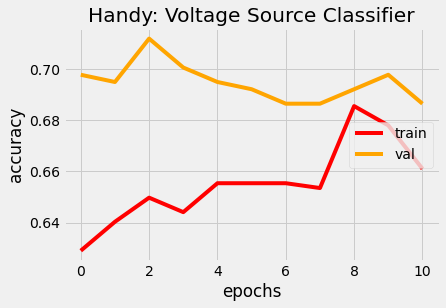

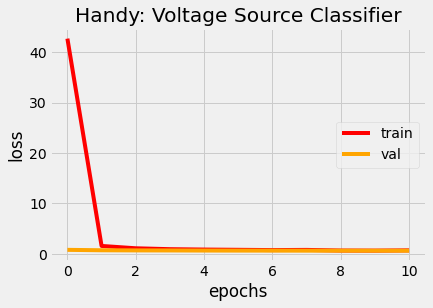

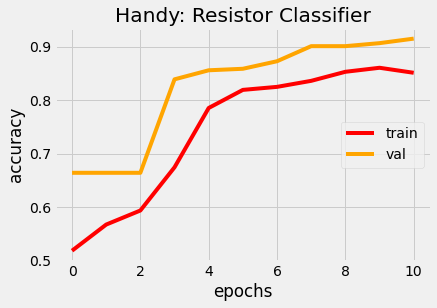

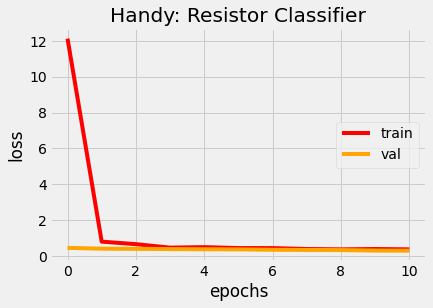

In [124]:
handy_classifier = Handy_RUN()

Voltage Source classifier label:  [[0.6539783  0.34602174]]
Resistor classifier label:  [[0.38863912 0.6113609 ]]
Resistor
Voltage Source classifier label:  [[0.6539783  0.34602174]]
Resistor classifier label:  [[0.38863912 0.6113609 ]]
Resistor
Voltage Source classifier label:  [[0.6539783  0.34602174]]
Resistor classifier label:  [[0.38863912 0.6113609 ]]
Resistor
Voltage Source classifier label:  [[0.6539783  0.34602174]]
Resistor classifier label:  [[0.38863912 0.6113609 ]]
Resistor
Voltage Source classifier label:  [[0.6539783  0.34602174]]
Resistor classifier label:  [[0.38863912 0.6113609 ]]
Resistor
Voltage Source classifier label:  [[0.6539783  0.34602174]]
Resistor classifier label:  [[0.38863912 0.6113609 ]]
Resistor
Voltage Source classifier label:  [[0.6539783  0.34602174]]
Resistor classifier label:  [[0.38863912 0.6113609 ]]
Resistor
Voltage Source classifier label:  [[0.6539783  0.34602174]]
Resistor classifier label:  [[0.38863912 0.6113609 ]]
Resistor
Voltage Source c

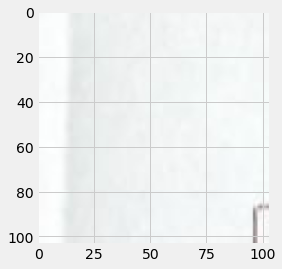

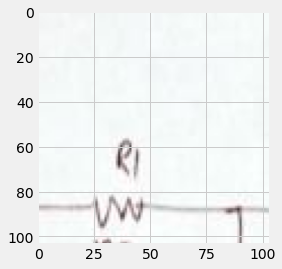

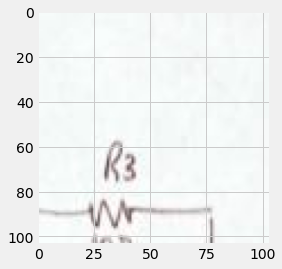

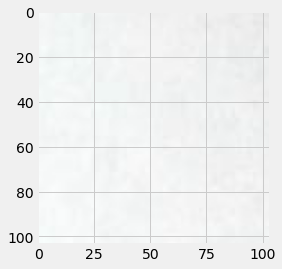

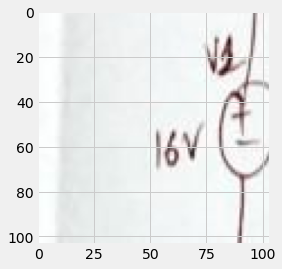

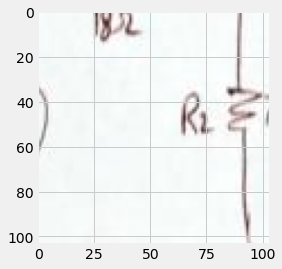

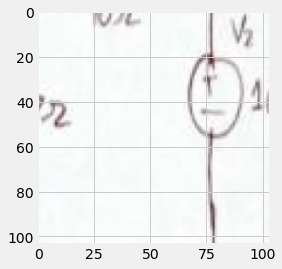

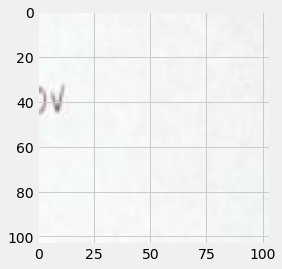

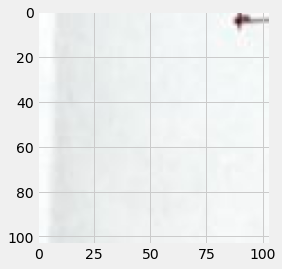

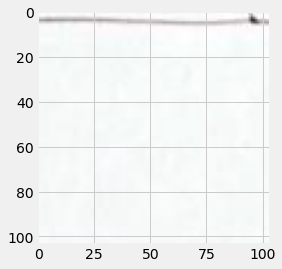

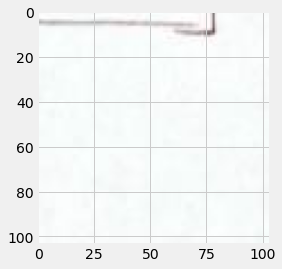

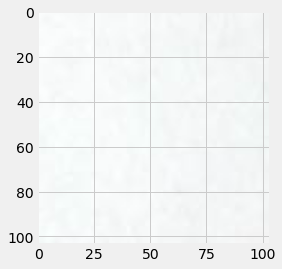

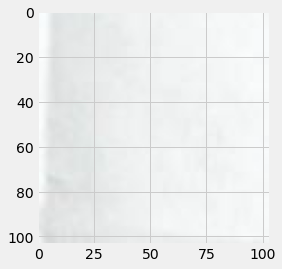

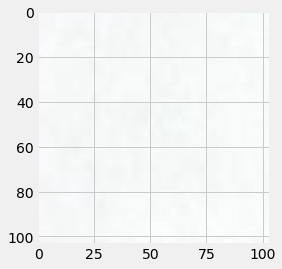

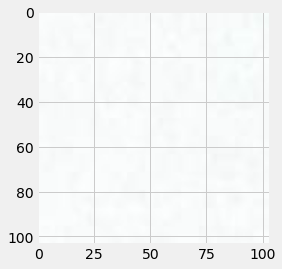

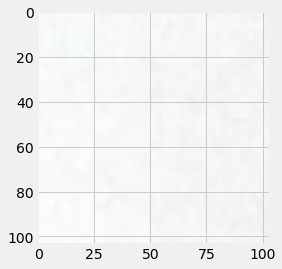

In [133]:
for i in os.listdir(CIRCUIT_TEST_DIRECTORY):
  if ".jpg" in i:
    img = cv2.imread(CIRCUIT_TEST_DIRECTORY + i)
    blocks = split_image(img,4)
    for j in blocks:

      voltage_category = classify(handy_classifier[0], j)
      resistor_category = classify(handy_classifier[1], j)

      print("Voltage Source classifier label: ", voltage_category)
      print("Resistor classifier label: ", resistor_category)

      if voltage_category[0][1] > resistor_category[0][1]:
        print("Voltage source")
      else:
        print("Resistor")
      plt.figure()
      plt.imshow(j)
    break

## Circuit Solver 

*Input:* Directed Graph \\
*Output:* Current and Voltage Values

#### Classes

In [101]:
class VoltageSource(object):
	def __init__(self, voltage, component_label):
		self.label = component_label
		self.type = "Voltage Source"
		self.value = voltage
		self.unit = "Volt"
	def __str__(self):
		return self.label + " is a " + str(self.value) + " " + self.unit + " Voltage Source."

In [102]:
class Resistor(object):
	def __init__(self, resistance, component_label):
		self.label = component_label
		self.type = "Resistor"
		self.value = resistance
		self.unit = "Ohm"
		self.current = 0; #Default current = 0 Amperes 

	def __str__(self):
		return self.label + " is a "  + str(self.value) + " " + self.unit + " Resistor."

In [103]:
class Component(object):
	def __init__(self, element):
		self.element = element
		self.label = self.element.label
	def __str__(self):	
		return self.element.__str__()

In [104]:
class Node(object):
	def __init__(self, label):
		self.label = label
		self.type = "Node"

	def __str__(self):
		return self.label + " is a " + self.type

In [105]:
class Circuit(object):
	# A directed Graph 
	# Add component not defined because 
	# isolated components in a circuit make no sense.

	# A simple series circuit 
	#Circuit with single loop single voltage source. 

	def __init__(self):
		# key: Component Label
		# value : Component Object 
		self.components = dict()
		
		# Edge list, connections between each component 
		# Tuples (comp1.label, comp2.label)
		# e.g. [("VS1", "R1"), ("R1", "R2"), ("R2", "R3"), ("R3", "R4"), ("R4", "VS1") ]
		self.connections = []


	def setup_basic(self, loop=2):
		if loop == 1:

			VS1 = Component(VoltageSource(20, "VS1"))

			R = [Component(Resistor(10, "R1")),
				 Component(Resistor(80, "R2")),
			 	 Component(Resistor(30, "R3"))]

			self.add_connection(VS1, R[0])
			self.add_connection(R[0], R[1])
			self.add_connection(R[1], R[2])
			self.add_connection(R[2], VS1)
		
		elif loop==2:
			VS1 = Component(VoltageSource(9, "VS1"))

			R  = [Component(Resistor(1000, "R1")),
				  Component(Resistor(2000, "R2")),
				  Component(Resistor(3000, "R3")),
				  Component(Resistor(2000, "R4"))]

			N1 = Component(Node("N1"))
			N2 = Component(Node("N2"))

			#add connections 
			self.add_connection(VS1, R[0])
			self.add_connection(R[0], N1)
			self.add_connection(N1, R[2])
			self.add_connection(R[2], N2)
			self.add_connection(N2, VS1)
			self.add_connection(R[1], N1)
			self.add_connection(R[3], R[1])
			self.add_connection(N2, R[3])

	def get_voltage_sources(self, lst):
		voltage_sources = []
		for i in self.components:
			if isinstance(self.components[i].element, VoltageSource):
				voltage_sources.append(i)
		return voltage_sources

	def get_resistors(self, lst):
		resistors = []
		for i in self.components:
			if isinstance(self.components[i].element, Resistor):
				resistors.append(i)
		return resistors

	def get_nodes(self):
		#Returns Node Objects
		nodes = []
		for i in self.components:
			if isinstance(self.components[i].element, Node):
				
				nodes.append(self.components[i])
		return nodes

	def add_connection(self, n1:Component, n2:Component):
		#Ensure each object is a Component object
		if not isinstance(n1, Component) or not isinstance(n2, Component):
			print("function add_connection requires objects of class Component")
			return False

		# Create a directed edge from n1 -> n2. 
		# Direction is direction of voltage flow
		
		#Adding components to Circuit (Graph)
		if n1.label not in self.components:
			self.components[n1.label] = n1

		if n2.label not in self.components:
			self.components[n2.label] = n2

		# if n2.label not in self.components:
		# 	self.components[n2.label] = n2

		new_edge = (n1.label, n2.label)

		#If list empty, just add edge.
		if len(self.connections) == 0:
			self.connections.append(new_edge)
			return new_edge
		
		#Ensure Edge doesnt already exist
		for i in self.connections:
			if i[0] != new_edge[0] and i[1] != new_edge[1]:
				self.connections.append(new_edge)
				return new_edge
		else:
			print("Connection already present.")
			return False

	def __str__(self):
		return str(self.connections)

	def get_loops(self):
		G = nx.DiGraph()
		G.add_nodes_from([i for i in self.components])
		G.add_edges_from(self.connections)
		loops = list(nx.simple_cycles(G))
		return loops
	


	def analyze(self):
		#Returns Current 
		loops = self.get_loops()

		print(loops)
		
		R = [[0 for i in range(len(loops))] for i in range(len(loops))]
		V = [0 for i in range(len(loops))]

		for i in range(len(loops)):
			R[i][i] = sum([self.components[j].element.value for j in loops[i] if isinstance(self.components[j].element, Resistor)])
			
			V[i] = sum([self.components[j].element.value for j in loops[i] if isinstance(self.components[j].element, VoltageSource)])

		# for i in range(len(loops)):
		# 	for j in range(i+1, len(loops)):

		
		R[1][0] = sum([self.components[i].element.value for i in set(loops[0]).intersection(set(loops[1])) if isinstance(self.components[i].element, Resistor)]) * -1
		R[0][1] = R[1][0]
		V[1] *= -1
		print(R)
		print(V)

		R = np.array(R)
		V = np.array(V)

		I = np.linalg.solve(R, V)
		return I

#### Manual Work

In [135]:
circuit1 = Circuit()

## COMPONENTS
VS1 = Component(VoltageSource(6, "VS1"))
R1 = Component(Resistor(14, "R1"))
N1 = Component(Node("N1"))
R2 = Component(Resistor(5, "R2"))
R3 = Component(Resistor(5, "R3"))
VS2 = Component(VoltageSource(5, "VS2"))
N2 = Component(Node("N2"))
R4 = Component(Resistor(10, "R4"))

##CONNECTIONS
circuit1.add_connection(VS1, R1)
circuit1.add_connection(R1, N1)
circuit1.add_connection(N1, R2)
circuit1.add_connection(R2, R3)
circuit1.add_connection(R3, N2)
circuit1.add_connection(N2, VS1)
circuit1.add_connection(VS2, R4)
circuit1.add_connection(R4, N1)
circuit1.add_connection(N2, VS2)

#refernce answers: 
# +184.2 mA, -157.9 mA

print(circuit1.analyze())

[['R1', 'N1', 'R2', 'R3', 'N2', 'VS1'], ['VS2', 'R4', 'N1', 'R2', 'R3', 'N2']]
[[24, -10], [-10, 20]]
[6, -5]
[ 0.18421053 -0.15789474]


In [107]:
test_annotations = {}

test_annotations_csv = open(CIRCUIT_TEST_DIRECTORY + "_annotations.csv")
first_line = True

for i in test_annotations_csv:
  if first_line:
    first_line = False
  else:
    ann_line = [j.strip() for j in i.split(',')]
    bbox_vals = dict()
    bbox_vals['width'] = int(ann_line[1])
    bbox_vals['height'] = int(ann_line[2])
    bbox_vals['class'] = ann_line[3]
    bbox_vals['xmin'] = int(ann_line[4])
    bbox_vals['ymin'] = int(ann_line[5])
    bbox_vals['xmax'] = int(ann_line[6])
    bbox_vals['ymax'] = int(ann_line[7])
    bbox_vals['centroid'] = calculate_centroid(int(ann_line[4]),
                                               int(ann_line[5]),
                                               int(ann_line[6]),
                                               int(ann_line[7]))

    if ann_line[0] in test_annotations:
      
      test_annotations[ann_line[0]].append(bbox_vals)
    else:
      test_annotations[ann_line[0]] = list()
      test_annotations[ann_line[0]].append(bbox_vals)

test_annotations_csv.close()

centroid: (131, 97)
centroid: (76, 158)
centroid: (176, 164)


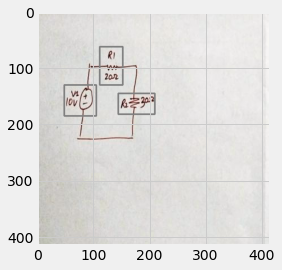

In [109]:
img_name = "33_png.rf.207c31506ca28f1bd925d1ed791dafa7.jpg"
img = cv2.imread(CIRCUIT_TEST_DIRECTORY + img_name)

for i in test_annotations[img_name]:
  pmin = (i['xmin'], i['ymin'])
  pmax = (i['xmax'], i['ymax'])

  print("centroid:", i['centroid'])

  cv2.rectangle(img, pmin, pmax, (127, 127, 127), 2)

plt.imshow(img)

In [134]:
boxes = test_annotations[img_name]
components = []

for box in boxes:
  center = box['centroid']
  other_boxes = [i['centroid'] for i in boxes if i != box]
  center_dists = [distance(center, j) for j in other_boxes]
  print(center_dists)

[82.13403679352427, 80.7093550959243]
[82.13403679352427, 100.17983829094555]
[80.7093550959243, 100.17983829094555]


# Archived Cells


In [ ]:
def preprocess(img):
  img = np.array(img)

  # # Smoothen to remove noise
  # kernel = np.ones((5,5),np.float32)/25
  # dst = cv2.filter2D(img,-1,kernel)
  median = cv2.medianBlur(img,5)

  # # Sharpen 
  kernel = np.array([[-1,-1,-1,-1,-1], [-1,-1,-1,-1,-1], [-1, -1, 25, -1, -1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]])
  sharp_img = cv2.filter2D(median, -1, kernel)

  # # Grayscale
  # gray_img = color.rgb2gray(sharp_img)

  # # Binarize 
  # threshold = 0.5
  # bin_img = (255 - (((gray_img) > threshold) * 255)).astype('uint8')

  # # er_di_kernel = np.ones((3,3), np.uint8)
  
  # img_dilation = cv2.dilate(bin_img, er_di_kernel, iterations=1)
  # img_erosion = cv2.erode(img_dilation, er_di_kernel, iterations=2)

  return sharp_img

In [ ]:

# for i in os.listdir(directory):
#   if ".jpg" in i:
#     img = Image.open("/content/test/" + i)
#     processed_img = preprocess(img)
#     plt.figure();
#     plt.imshow(processed_img, cmap='gray')

In [ ]:
# Want to save bounding box images? 
save_imgs = False

for file in x:
  if not is_img_empty(file)[0]:
    # apply craft text detection and export detected regions to output directory
    prediction_result = craft.detect_text(file)
    bounding_boxes = prediction_result['boxes_as_ratios']
    bbox_count = len(bounding_boxes)

    for i in range(bbox_count):
      for j in range(len(bounding_boxes[i])):
        bounding_boxes[i][j][0] = bounding_boxes[i][j][0] * IMG_DIM[0]
        bounding_boxes[i][j][1] = bounding_boxes[i][j][1] * IMG_DIM[1]

      p_min = (int(bounding_boxes[i][0][0]), int(bounding_boxes[i][0][1]))
      p_max = (int(bounding_boxes[i][2][0]), int(bounding_boxes[i][2][1]))

      cropped_img = file[p_min[0]:p_max[0], p_min[1]:p_max[1]]

      x_min = int(prediction_result['boxes'][0][0][0])
      x_max = int(prediction_result['boxes'][0][2][0])
      y_min = int(prediction_result['boxes'][0][0][1])
      y_max = int(prediction_result['boxes'][0][2][1])

      plt.figure()
      plt.imshow(file[x_min:x_max, y_min:y_max, :])

      # cv2.rectangle(file, p_min, p_max, (127,127,127), 1)
    
    # plt.figure();
    # plt.imshow(file)

    if save_imgs:
      cv2.imwrite("BBoxes_" + image_name, file)

In [ ]:
if not CRAFT_INSTALLED:
  !pip install craft-text-detector
  CRAFT_INSTALLED = True

In [ ]:
craft_output = '/content/outputs/'

# create a craft instance
craft = Craft(output_dir=craft_output, crop_type="poly", cuda=True)

In [ ]:
images_dir = TRAIN_DIRECTORY

# Want to save bounding box images? 
save_imgs = False


for file in os.listdir(images_dir):
  if ".jpg" in file:
    image_name = file
     # set image path and export folder directory
    image = cv2.imread(images_dir + image_name) # can be filepath, PIL image or numpy array

    # apply craft text detection and export detected regions to output directory
    prediction_result = craft.detect_text(image)
    bounding_boxes = prediction_result['boxes_as_ratios']
    bbox_count = len(bounding_boxes)

    for i in range(bbox_count):
      for j in range(len(bounding_boxes[i])):
        bounding_boxes[i][j][0] = bounding_boxes[i][j][0] * IMG_DIM[0]
        bounding_boxes[i][j][1] = bounding_boxes[i][j][1] * IMG_DIM[1]

      p_min = (int(bounding_boxes[i][0][0]), int(bounding_boxes[i][0][1]))
      p_max = (int(bounding_boxes[i][2][0]), int(bounding_boxes[i][2][1]))
      cv2.rectangle(image, p_min, p_max, (255,0,0), 2)
    
    plt.figure();
    plt.imshow(image)

    if save_imgs:
      cv2.imwrite("BBoxes_" + image_name, image)

In [ ]:
# unload models from ram/gpu
craft.unload_craftnet_model()
craft.unload_refinenet_model()